# TRABAJO PRÁCTICO GRUPO 4 - LIMPIEZA DEL DATASET PROPERATI

## Datos geoespaciales

Comenzamos con la importación de las librerías que utilizaremos para trabajar con datos geográficos.

In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import shapely
import descartes
import pyproj

Importamos el Dataset en formato csv indicando la separación por comas, y llamamos al Dataset "data".

Llamamos una muestra de las primeras filas para observar cómo es la información contenida en el dataset y tenerla de referencia a la hora de tomar decisiones futuras.

In [27]:
archivo_resolucion = pd.read_csv("../TP1/resolucion.csv", sep=",")

columnas_seleccionadas = ['property_type', 'place_name_clean', 'country_name', 'state_name', 'lat_clean', 'lon_clean', 'rooms_clean', 'price_usd_per_m2_clean', 'surface_total_m2_clean']

geo_data = archivo_resolucion[columnas_seleccionadas]

geo_data.head()

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,2.0,1127.27,55.0
1,apartment,La Plata,Argentina,Bs.As. G.B.A. Zona Sur,-34.903883,-57.964330,3.0,NaN,NaN
2,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,2.0,1309.09,55.0
3,PH,Liniers,Argentina,Capital Federal,-34.647797,-58.516424,3.0,NaN,NaN
4,apartment,Centro,Argentina,Buenos Aires Costa Atlántica,-38.002626,-57.549447,2.0,1828.57,35.0


In [28]:
geo_data_null_inicial = geo_data.isnull().sum() / geo_data.shape[0] * 100
geo_data_null_inicial.round(2) 

property_type              0.00
place_name_clean           0.00
country_name               0.00
state_name                 0.00
lat_clean                  6.89
lon_clean                  6.89
rooms_clean                0.00
price_usd_per_m2_clean    23.37
surface_total_m2_clean    16.10
dtype: float64

Generamos una columna geometry y transformamos el dataset en un geodataset para trabajar con las librerías de Geopandas

In [29]:
geometria = gpd.points_from_xy(geo_data.lon_clean, geo_data.lat_clean)
geo_df_data = gpd.GeoDataFrame(geo_data, geometry=geometria)

In [30]:
geo_df_data.loc[:4, ['geometry', 'lat_clean', 'lon_clean','property_type','place_name_clean']]

,geometry,lat_clean,lon_clean,property_type,place_name_clean
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-57.96433 -34.90388),-34.903883,-57.964330,apartment,La Plata
2,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
3,POINT (-58.51642 -34.64780),-34.647797,-58.516424,PH,Liniers
4,POINT (-57.54945 -38.00263),-38.002626,-57.549447,apartment,Centro


Buscamos outliers para eliminarlos previo a la generación del mapa de puntos

In [31]:
geo_df_data_sorted_lon = geo_df_data.sort_values(by='lon_clean', ascending=False)
geo_df_data_sorted_lon.head(3)

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean,geometry
40652,house,Bernardo de Irigoyen,Argentina,Misiones,-26.25543,-53.64682,5.0,NaN,NaN,POINT (-53.64682 -26.25543)
59726,store,Misiones,Argentina,Misiones,-26.33333,-53.73333,1.0,NaN,NaN,POINT (-53.73333 -26.33333)
83949,house,Misiones,Argentina,Misiones,-26.81427,-54.34387,1.0,6917.7024,NaN,POINT (-54.34387 -26.81427)


In [32]:
geo_df_data_sorted_lat = geo_df_data.sort_values(by='lat_clean', ascending=False)
geo_df_data_sorted_lat.head(3)

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean,geometry
9711,house,Córdoba,Argentina,Córdoba,4.545843,-75.678931,3.0,NaN,NaN,POINT (-75.67893 4.54584)
98428,house,Jujuy,Argentina,Jujuy,-23.000000,-66.000000,6.0,33030.90,5651.0,POINT (-66.00000 -23.00000)
38291,apartment,San Ramón de la Nueva Orán,Argentina,Salta,-23.137164,-64.313237,4.0,583.33,85.0,POINT (-64.31324 -23.13716)


In [33]:
geo_df_data.loc[9711]

property_type                                      house
place_name_clean                                 Córdoba
country_name                                   Argentina
state_name                                       Córdoba
lat_clean                                       4.545843
lon_clean                                     -75.678931
rooms_clean                                          3.0
price_usd_per_m2_clean                               NaN
surface_total_m2_clean                               NaN
geometry                  POINT (-75.67893099 4.5458426)
Name: 9711, dtype: object

In [34]:
geo_df_data = geo_df_data.drop(9711)

### Localización propiedades en Argentina

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

argentina = world[world.name == 'Argentina']

fig, ax = plt.subplots(figsize=(10, 10))

argentina.plot(ax=ax, color='lightgrey', edgecolor='black')

geo_df_data.plot(ax=ax, markersize=5, color='red', marker='o', label='Propiedades')

plt.title('Propiedades en Argentina')
plt.legend()
plt.show()

### Localización propiedades en el AMBA

Generamos una máscara que incluya a los datos de propiedades de CABA y Buenos Aires para poder graficarlos en mapas más detallados, ya que son la amplia mayoría de los registros del dataset original

In [ ]:
conditions = [
    'Capital Federal',
    'Bs.As. G.B.A. Zona Norte',
    'Bs.As. G.B.A. Zona Sur',
    'Bs.As. G.B.A. Zona Oeste',
    'Buenos Aires Interior',
    'Buenos Aires Costa Atlántica'
]

mask_buenos_aires = geo_data['state_name'].isin(conditions)
geo_data_bsas = geo_data[mask_buenos_aires]

geometria_bsas = gpd.points_from_xy(geo_data_bsas.lon_clean, geo_data_bsas.lat_clean)
geo_df_data_bsas = gpd.GeoDataFrame(geo_data_bsas, geometry=geometria_bsas)

geo_df_data_bsas.head(3)

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean,geometry
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,2.0,1127.27,55.0,POINT (-58.50884 -34.66182)
1,apartment,La Plata,Argentina,Bs.As. G.B.A. Zona Sur,-34.903883,-57.964330,3.0,NaN,NaN,POINT (-57.96433 -34.90388)
2,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,2.0,1309.09,55.0,POINT (-58.52298 -34.65226)


#### Localización propiedades n la Ciudad Autónoma de Buenos Aires

In [ ]:
df_barrios = pd.read_csv("../TP1/barrios.csv", encoding='latin1')

df_barrios["WKT"] = df_barrios["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(df_barrios, geometry='WKT')
geo_barrios.sample(10)

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
26,"POLYGON ((-58.47082 -34.58745, -58.47082 -34.5...",PARQUE CHAS,15.0,4531.253396,1.385412e+06
22,"POLYGON ((-58.48098 -34.56264, -58.48023 -34.5...",VILLA URQUIZA,12.0,10021.459665,5.449059e+06
21,"POLYGON ((-58.47242 -34.56610, -58.47296 -34.5...",COGHLAN,12.0,4627.563131,1.279951e+06
9,"POLYGON ((-58.44525 -34.64204, -58.44424 -34.6...",FLORES,7.0,15772.425185,8.590784e+06
30,"POLYGON ((-58.47038 -34.63879, -58.47001 -34.6...",PARQUE AVELLANEDA,9.0,10165.627129,4.732708e+06
20,"POLYGON ((-58.48813 -34.56129, -58.48827 -34.5...",SAAVEDRA,12.0,11132.139346,5.538677e+06
18,"POLYGON ((-58.46571 -34.65903, -58.46519 -34.6...",VILLA LUGANO,8.0,15057.468389,9.296142e+06
28,"POLYGON ((-58.46055 -34.57794, -58.46022 -34.5...",VILLA ORTUZAR,15.0,5684.995211,1.853802e+06
16,"POLYGON ((-58.41037 -34.64830, -58.41210 -34.6...",PARQUE PATRICIOS,4.0,7878.468115,3.743507e+06
43,"POLYGON ((-58.45159 -34.53153, -58.45152 -34.5...",BELGRANO,13.0,21504.197774,7.932303e+06


In [ ]:
# Realizar una unión espacial para encontrar puntos dentro de los límites de los barrios
from geopandas.tools import sjoin
merged = sjoin(geo_df_data_bsas, geo_barrios, how='inner', op='within')

# Crear una columna 'geometry_clean' con los valores que se encuentran dentro de los límites de los barrios
geo_df_data_bsas['geometry_clean'] = merged['geometry']

geo_df_data_bsas_clean = geo_df_data_bsas['geometry_clean']

geo_df_data_bsas_clean.head()


0    POINT (-58.50884 -34.66182)
1                           None
2    POINT (-58.52298 -34.65226)
3    POINT (-58.51642 -34.64780)
4                           None
Name: geometry_clean, dtype: geometry

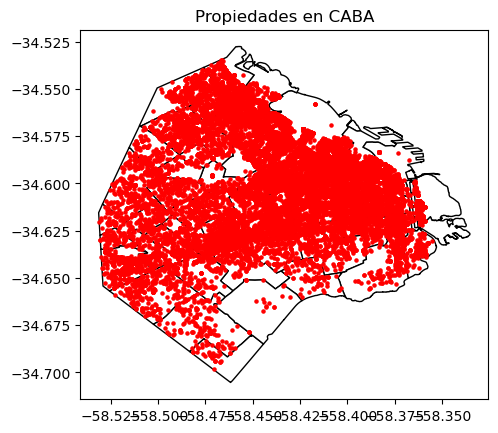

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_barrios.plot(ax=ax, color='white', edgecolor='black')

geo_df_data_bsas_clean.plot(ax=ax, color='red', markersize=5)

plt.title('Propiedades en CABA')
plt.show()

In [ ]:
geo_df_data_bsas.head()

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean,geometry,geometry_clean
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,2.0,1127.27,55.0,POINT (-58.50884 -34.66182),POINT (-58.50884 -34.66182)
1,apartment,La Plata,Argentina,Bs.As. G.B.A. Zona Sur,-34.903883,-57.964330,3.0,NaN,NaN,POINT (-57.96433 -34.90388),None
2,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,2.0,1309.09,55.0,POINT (-58.52298 -34.65226),POINT (-58.52298 -34.65226)
3,PH,Liniers,Argentina,Capital Federal,-34.647797,-58.516424,3.0,NaN,NaN,POINT (-58.51642 -34.64780),POINT (-58.51642 -34.64780)
4,apartment,Centro,Argentina,Buenos Aires Costa Atlántica,-38.002626,-57.549447,2.0,1828.57,35.0,POINT (-57.54945 -38.00263),None


#### Localización propiedades resto del Área Metropolitana de Buenos Aires

In [ ]:
conditions = [
    'Capital Federal',
    'Bs.As. G.B.A. Zona Norte',
    'Bs.As. G.B.A. Zona Sur',
    'Bs.As. G.B.A. Zona Oeste',
    'Buenos Aires Interior',
    'Buenos Aires Costa Atlántica'
]

mask_buenos_aires = geo_data['state_name'].isin(conditions)
geo_data_bsas = geo_data[mask_buenos_aires]

geometria_bsas = gpd.points_from_xy(geo_data_bsas.lon_clean, geo_data_bsas.lat_clean)
geo_df_data_bsas = gpd.GeoDataFrame(geo_data_bsas, geometry=geometria_bsas)

geo_df_data_bsas.head(3)

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean,geometry
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,2.0,1127.27,55.0,POINT (-58.50884 -34.66182)
1,apartment,La Plata,Argentina,Bs.As. G.B.A. Zona Sur,-34.903883,-57.964330,3.0,NaN,NaN,POINT (-57.96433 -34.90388)
2,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,2.0,1309.09,55.0,POINT (-58.52298 -34.65226)


In [ ]:
provincia= pd.read_csv(".../TP1/provincia.shp")

df_barrios["WKT"] = df_barrios["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(df_barrios, geometry='WKT')
geo_barrios.sample(10)
provincia.head()

FileNotFoundError: [Errno 2] No such file or directory: '.../TP1/provincia.shp'

In [ ]:
geometria = gpd.points_from_xy(geo_df_data_bsas.lon_clean, geo_df_data_bsas.lat_clean)
geo_df_data_bsas = gpd.GeoDataFrame(geo_df_data_bsas, geometry=geometria)

In [ ]:
geo_df_data_bsas.loc[:4, ['geometry', 'lat_clean', 'lon_clean','property_type','place_name_clean']]

,geometry,lat_clean,lon_clean,property_type,place_name_clean
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-57.96433 -34.90388),-34.903883,-57.964330,apartment,La Plata
2,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
3,POINT (-58.51642 -34.64780),-34.647797,-58.516424,PH,Liniers
4,POINT (-57.54945 -38.00263),-38.002626,-57.549447,apartment,Centro


In [ ]:
# Leer el shapefile completo
data_todas_las_provincias = gpd.read_file("../TP1/provincia.shp")

# Filtrar solo la provincia de Buenos Aires
provincia_buenos_aires = data_todas_las_provincias[data_todas_las_provincias['nam'] == 'Buenos Aires']

# Visualizar la provincia de Buenos Aires
provincia_buenos_aires.plot()
plt.show()

DriverError: ../TP1/provincia.shp: No such file or directory

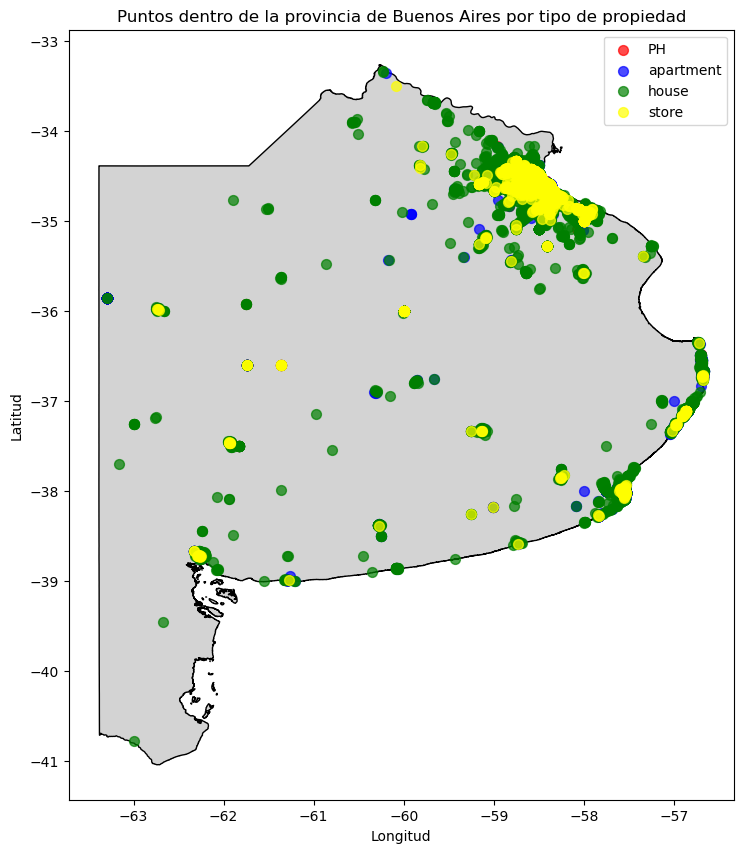

In [ ]:
# Leer el shapefile completo de la provincia de Buenos Aires
data_todas_las_provincias = gpd.read_file("../TP1/provincia.shp")
provincia_buenos_aires = data_todas_las_provincias[data_todas_las_provincias['nam'] == 'Buenos Aires']

# Crear un mapa base con la provincia de Buenos Aires
fig, ax = plt.subplots(figsize=(10, 10))
provincia_buenos_aires.plot(ax=ax, color='lightgray', edgecolor='black')

# Filtrar los puntos dentro de los límites de la provincia de Buenos Aires
geo_df_data_bsas_clean_clipped = geo_df_data_bsas.cx[provincia_buenos_aires.total_bounds[0]:provincia_buenos_aires.total_bounds[2], 
                                                           provincia_buenos_aires.total_bounds[1]:provincia_buenos_aires.total_bounds[3]]

# Segmentar los puntos por tipo de propiedad y asignar colores
property_types = geo_df_data_bsas_clean_clipped['property_type'].unique()
colors = ['red', 'blue', 'green', 'yellow', 'purple']  # Puedes agregar más colores si hay más tipos de propiedad

for prop_type, color in zip(property_types, colors):
    geo_df_data_bsas_clean_clipped[geo_df_data_bsas_clean_clipped['property_type'] == prop_type].plot(
        ax=ax, color=color, markersize=50, label=prop_type, alpha=0.7
    )

# Configurar el gráfico
plt.title('Puntos dentro de la provincia de Buenos Aires por tipo de propiedad')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
conditions = [
    'Santa Fe'
]

mask_santafe = geo_data['state_name'].isin(conditions)
geo_data_stafe = geo_data[mask_santafe]

geometria_stafe = gpd.points_from_xy(geo_data_stafe.lon_clean, geo_data_stafe.lat_clean)
geo_df_data_stafe = gpd.GeoDataFrame(geo_data_stafe, geometry=geometria_stafe)

geo_df_data_stafe.head(3)

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean,geometry
9,house,Rosario,Argentina,Santa Fe,-32.942031,-60.725919,3.0,NaN,NaN,POINT (-60.72592 -32.94203)
64,house,Rosario,Argentina,Santa Fe,-32.919670,-60.759419,3.0,276.5,1085.0,POINT (-60.75942 -32.91967)
83,apartment,Rosario,Argentina,Santa Fe,-32.954877,-60.651838,2.0,NaN,55.0,POINT (-60.65184 -32.95488)


In [ ]:
geometria = gpd.points_from_xy(geo_df_data_stafe.lon_clean, geo_df_data_stafe.lat_clean)
geo_df_data_stafe = gpd.GeoDataFrame(geo_df_data_stafe, geometry=geometria)

In [ ]:
geo_df_data_stafe.loc[:100, ['geometry', 'lat_clean', 'lon_clean','property_type','place_name_clean']]

,geometry,lat_clean,lon_clean,property_type,place_name_clean
9,POINT (-60.72592 -32.94203),-32.942031,-60.725919,house,Rosario
64,POINT (-60.75942 -32.91967),-32.919670,-60.759419,house,Rosario
83,POINT (-60.65184 -32.95488),-32.954877,-60.651838,apartment,Rosario
84,POINT (-60.65339 -32.93277),-32.932766,-60.653385,apartment,Rosario
85,POINT (-60.64564 -32.95884),-32.958837,-60.645641,apartment,Rosario
100,POINT (-60.67109 -32.93523),-32.935230,-60.671086,apartment,Rosario


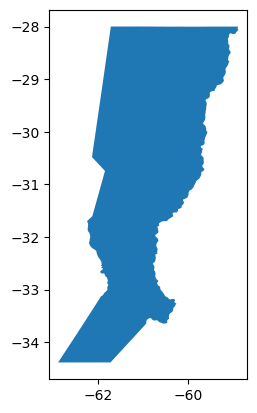

In [ ]:
# Filtrar solo la provincia de Sta Fe
provincia_santa_fe = data_todas_las_provincias[data_todas_las_provincias['nam'] == 'Santa Fe']

# Visualizar la provincia de Buenos Aires
provincia_santa_fe.plot()
plt.show()

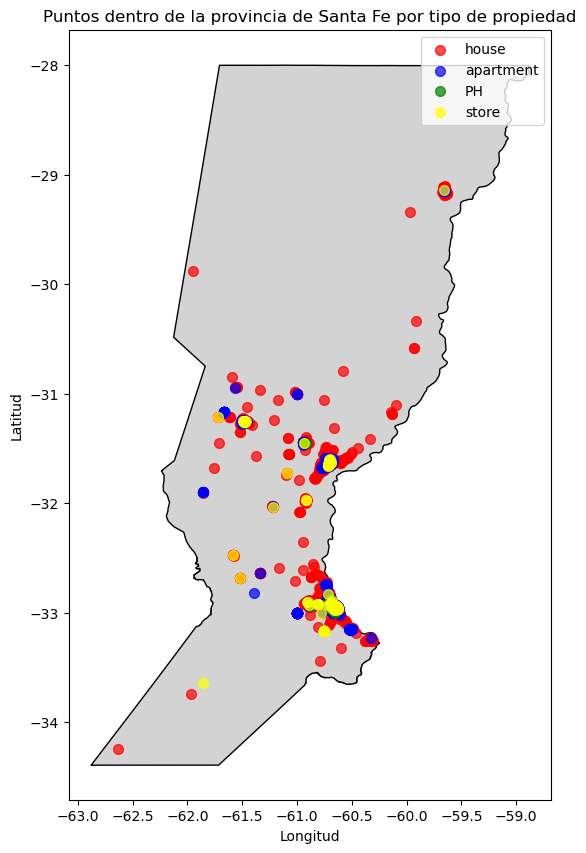

In [ ]:
# Leer el shapefile completo de la provincia de Santa Fe
data_todas_las_provincias = gpd.read_file("../TP1/provincia.shp")
provincia_stafe = data_todas_las_provincias[data_todas_las_provincias['nam'] == 'Santa Fe']

# Crear un mapa base con la provincia de Santa
fig, ax = plt.subplots(figsize=(10, 10))
provincia_stafe.plot(ax=ax, color='lightgray', edgecolor='black')

# Filtrar los puntos dentro de los límites de la provincia de Santa Fe
geo_df_data_stafe_clean_clipped = geo_df_data_stafe.cx[provincia_stafe.total_bounds[0]:provincia_stafe.total_bounds[2], 
                                                           provincia_stafe.total_bounds[1]:provincia_stafe.total_bounds[3]]

# Segmentar los puntos por tipo de propiedad y asignar colores
property_types = geo_df_data_stafe_clean_clipped['property_type'].unique()
colors = ['red', 'blue', 'green', 'yellow', 'purple']  # Puedes agregar más colores si hay más tipos de propiedad

for prop_type, color in zip(property_types, colors):
    geo_df_data_stafe_clean_clipped[geo_df_data_stafe_clean_clipped['property_type'] == prop_type].plot(
        ax=ax, color=color, markersize=50, label=prop_type, alpha=0.7
    )

# Configurar el gráfico
plt.title('Puntos dentro de la provincia de Santa Fe por tipo de propiedad')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
conditions = [
    'Córdoba'
]

mask_cordoba = geo_data['state_name'].isin(conditions)
geo_data_cordoba = geo_data[mask_cordoba]

geometria_cordoba = gpd.points_from_xy(geo_data_cordoba.lon_clean, geo_data_cordoba.lat_clean)
geo_df_data_cordoba = gpd.GeoDataFrame(geo_data_cordoba, geometry=geometria_cordoba)

geo_df_data_cordoba.head(3)

,property_type,place_name_clean,country_name,state_name,lat_clean,lon_clean,rooms_clean,price_usd_per_m2_clean,surface_total_m2_clean,geometry
10,house,Córdoba,Argentina,Córdoba,-31.420083,-64.188776,4.0,46.24,1514.0,POINT (-64.18878 -31.42008)
20,house,Villa Giardino,Argentina,Córdoba,-31.052985,-64.499128,3.0,NaN,148.0,POINT (-64.49913 -31.05299)
32,apartment,Córdoba,Argentina,Córdoba,-31.405374,-64.156267,3.0,616.92,50.0,POINT (-64.15627 -31.40537)


In [ ]:
geometria = gpd.points_from_xy(geo_df_data_cordoba.lon_clean, geo_df_data_cordoba.lat_clean)
geo_df_data_cordoba = gpd.GeoDataFrame(geo_df_data_cordoba, geometry=geometria)

In [ ]:
geo_df_data_cordoba.loc[:40, ['geometry', 'lat_clean', 'lon_clean','property_type','place_name_clean']]

,geometry,lat_clean,lon_clean,property_type,place_name_clean
10,POINT (-64.18878 -31.42008),-31.420083,-64.188776,house,Córdoba
20,POINT (-64.49913 -31.05299),-31.052985,-64.499128,house,Villa Giardino
32,POINT (-64.15627 -31.40537),-31.405374,-64.156267,apartment,Córdoba
37,POINT (-64.45801 -31.43732),-31.437318,-64.458006,house,Malagueño


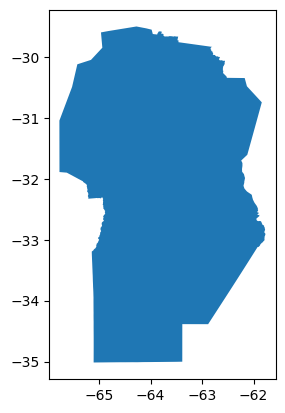

In [ ]:
# Filtrar solo la provincia de Cordoba
provincia_cordoba= data_todas_las_provincias[data_todas_las_provincias['nam'] == 'Córdoba']

# Visualizar la provincia de Cordoba
provincia_cordoba.plot()
plt.show()

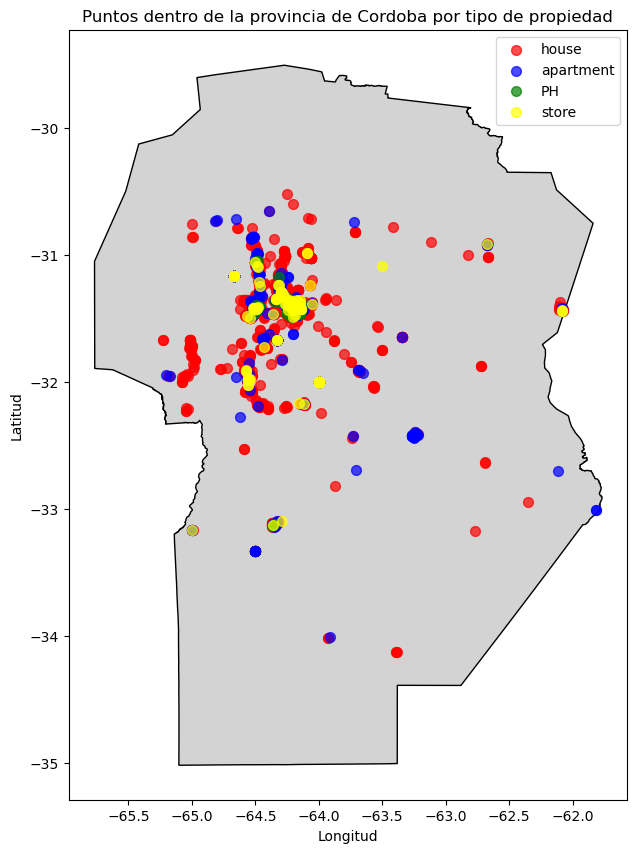

In [ ]:
# Leer el shapefile completo de la provincia de Cordoba
data_todas_las_provincias = gpd.read_file("../TP1/provincia.shp")
provincia_cordoba = data_todas_las_provincias[data_todas_las_provincias['nam'] == 'Córdoba']

# Crear un mapa base con la provincia de Cordoba
fig, ax = plt.subplots(figsize=(10, 10))
provincia_cordoba.plot(ax=ax, color='lightgray', edgecolor='black')

# Filtrar los puntos dentro de los límites de la provincia de Cordoba
geo_df_data_cordoba_clean_clipped = geo_df_data_cordoba.cx[provincia_cordoba.total_bounds[0]:provincia_cordoba.total_bounds[2], 
                                                           provincia_cordoba.total_bounds[1]:provincia_cordoba.total_bounds[3]]

# Segmentar los puntos por tipo de propiedad y asignar colores
property_types = geo_df_data_cordoba_clean_clipped['property_type'].unique()
colors = ['red', 'blue', 'green', 'yellow', 'purple']  # Puedes agregar más colores si hay más tipos de propiedad

for prop_type, color in zip(property_types, colors):
    geo_df_data_cordoba_clean_clipped[geo_df_data_cordoba_clean_clipped['property_type'] == prop_type].plot(
        ax=ax, color=color, markersize=50, label=prop_type, alpha=0.7
    )

# Configurar el gráfico
plt.title('Puntos dentro de la provincia de Cordoba por tipo de propiedad')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()

# Mostrar el gráfico
plt.show()